In [1]:
# --- INSTALL DEPENDENCIES ---
!pip install transformers datasets scikit-learn wandb accelerate sentencepiece -q

In [4]:
# Polarization Detection Shared Task - Subtask 2 (English)
# Multi-Label Classification: Political, Racial/Ethnic, Religious, Gender/Sexual, Other
# Using microsoft/deberta-v3-base

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
set_seed(42)

# ============================================================================
# CONFIGURATION
# ============================================================================
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
BATCH_SIZE = 16
GRAD_ACCUMULATION = 1
LEARNING_RATE = 1e-5
EPOCHS = 8
WARMUP_RATIO = 0.1

# Label columns for multi-label classification
LABEL_COLS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Task: Multi-Label Classification (Subtask 2)")
print(f"  Labels: {LABEL_COLS}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")

# Check for GPU
if not torch.cuda.is_available():
    print("\nWARNING: Running on CPU. Switch to GPU for faster training.")
    print("Go to Runtime > Change runtime type > T4 GPU")
else:
    print(f"\nGPU Detected: {torch.cuda.get_device_name(0)}")

# ============================================================================
# LOAD DATA
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Path configuration - adjust this to your folder structure
DATA_PATH = "/content/drive/MyDrive/AIMS/NLP/dev_phase/subtask2"

try:
    train_df = pd.read_csv(f"{DATA_PATH}/train/eng.csv")
    test_df = pd.read_csv(f"{DATA_PATH}/dev/eng.csv")
    print(f"\nLoaded {len(train_df)} training rows from train/eng.csv")
    print(f"Loaded {len(test_df)} test rows from dev/eng.csv")
    print(f"Training columns: {train_df.columns.tolist()}")
except FileNotFoundError as e:
    raise ValueError(f"Could not find files in {DATA_PATH}. Please check the path.\nError: {e}")

Configuration:
  Model: microsoft/deberta-v3-base
  Task: Multi-Label Classification (Subtask 2)
  Labels: ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
  Max Length: 256
  Batch Size: 16
  Learning Rate: 1e-05
  Epochs: 8

GPU Detected: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Loaded 3222 training rows from train/eng.csv
Loaded 160 test rows from dev/eng.csv
Training columns: ['id', 'text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']



--- Data Preprocessing ---
Cleaned training data shape: (3222, 7)

Label Distribution (Multi-Label):
  political: 1150 (35.69%)
  racial/ethnic: 281 (8.72%)
  religious: 112 (3.48%)
  gender/sexual: 72 (2.23%)
  other: 126 (3.91%)

Cleaned test data shape: (160, 7)

--- Class Weights (Per Label) ---
  political: 1.80x
  racial/ethnic: 10.45x
  religious: 27.65x
  gender/sexual: 43.46x
  other: 24.48x

--- Data Split ---
Training samples: 2738
Validation samples: 484
Test samples: 160

Validation Label Distribution:
  political: 147 (30.37%)
  racial/ethnic: 37 (7.64%)
  religious: 14 (2.89%)
  gender/sexual: 9 (1.86%)
  other: 22 (4.55%)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]


Datasets created:
  Train dataset size: 2738
  Validation dataset size: 484


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded successfully

STARTING TRAINING (SUBTASK 2 - MULTI-LABEL)



Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,F1 Weighted,F1 Political,F1 Racial/ethnic,F1 Religious,F1 Gender/sexual,F1 Other
1,1.173200,1.101730,0.009756,0.008584,0.007882,0.000000,0.048780,0.000000,0.000000,0.000000
2,1.217900,0.901497,0.288214,0.361497,0.511157,0.664557,0.308511,0.158940,0.082645,0.226415
3,1.103800,0.855408,0.325127,0.440926,0.560868,0.715976,0.381579,0.208696,0.067416,0.251969
4,0.874000,0.886239,0.345035,0.449735,0.559809,0.696774,0.433566,0.230769,0.116279,0.247788
5,0.835000,0.865644,0.353441,0.464198,0.566672,0.705202,0.418919,0.226415,0.133333,0.283333
6,0.691000,0.900464,0.361300,0.477922,0.570593,0.701754,0.452555,0.242424,0.126582,0.283186
7,0.738100,0.924658,0.372573,0.487805,0.579632,0.709480,0.466165,0.279570,0.129870,0.277778
8,0.717600,0.914113,0.369297,0.479470,0.575030,0.705167,0.462687,0.262626,0.148148,0.267857



Training completed successfully



--- Validation Results (0.5 threshold) ---
Macro F1: 0.3726
Micro F1: 0.4878
Weighted F1: 0.5796

Per-Label F1 Scores:
  political: 0.7095
  racial/ethnic: 0.4662
  religious: 0.2796
  gender/sexual: 0.1299
  other: 0.2778

THRESHOLD OPTIMIZATION (PER LABEL)
  political: Threshold=0.525 | F1=0.7121
  racial/ethnic: Threshold=0.925 | F1=0.4935
  religious: Threshold=0.925 | F1=0.3810
  gender/sexual: Threshold=0.425 | F1=0.1481
  other: Threshold=0.325 | F1=0.2833

--- Optimized Validation Scores ---
Macro F1: 0.4036
Micro F1: 0.5132
Weighted F1: 0.5932

VALIDATION SET PERFORMANCE

Detailed Classification Report:
               precision    recall  f1-score   support

    political     0.6534    0.7823    0.7121       147
racial/ethnic     0.4750    0.5135    0.4935        37
    religious     0.2857    0.5714    0.3810        14
gender/sexual     0.0833    0.6667    0.1481         9
        other     0.1735    0.7727    0.2833        22

    micro avg     0.3986    0.7205    0.5132   

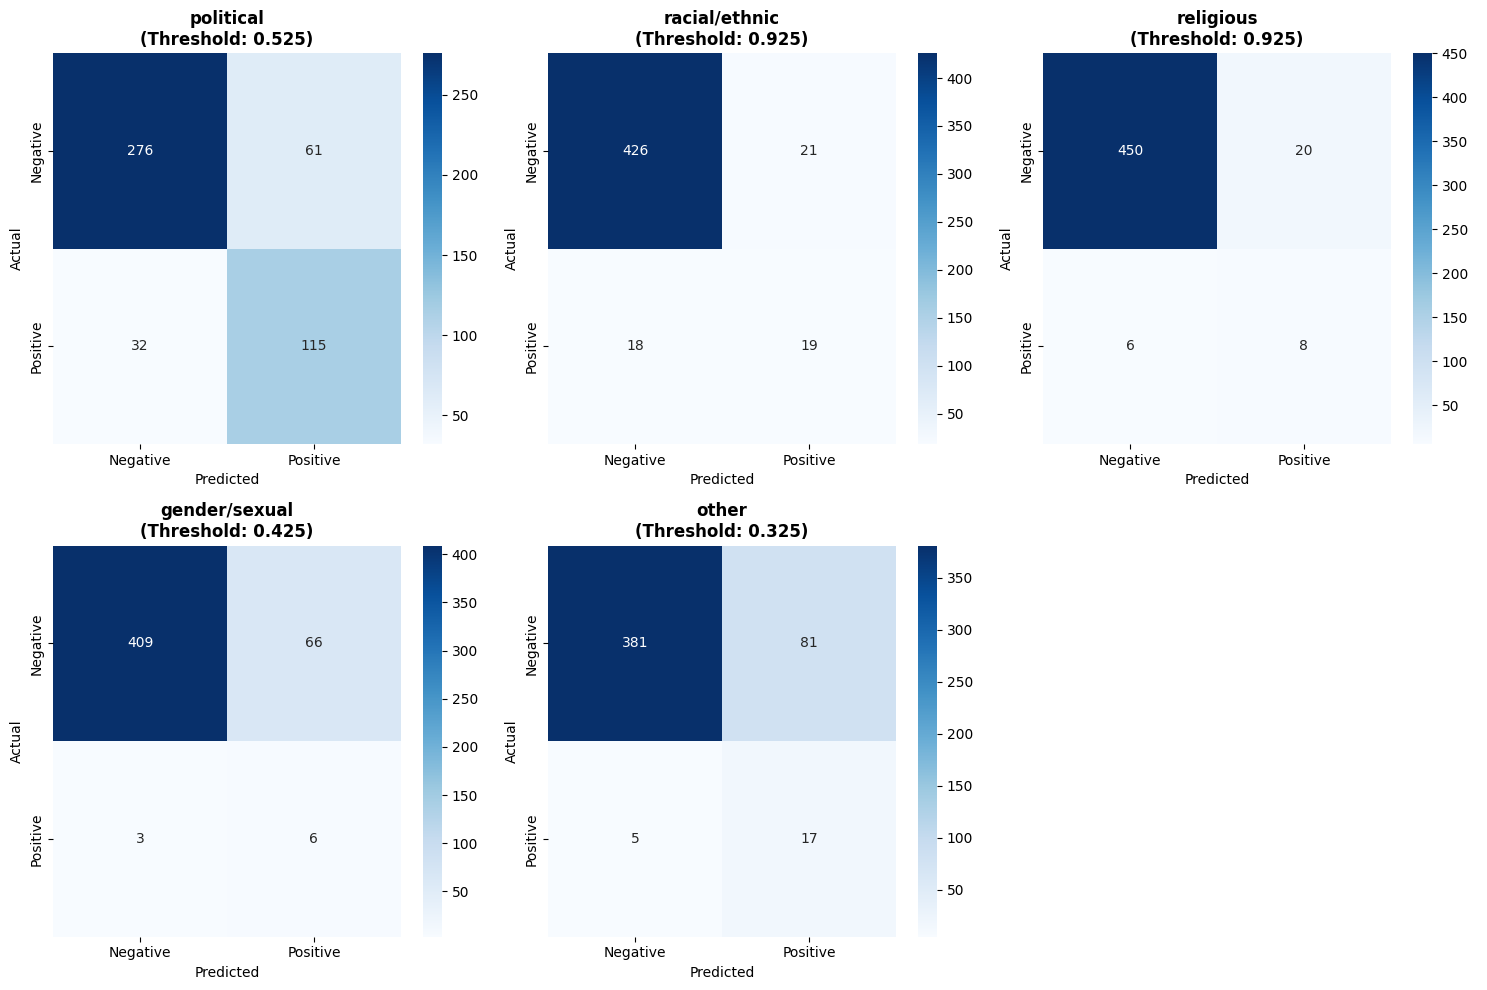


Per-Label Detailed Metrics:
  political:
    Precision: 0.6534
    Recall:    0.7823
    F1 Score:  0.7121
  racial/ethnic:
    Precision: 0.4750
    Recall:    0.5135
    F1 Score:  0.4935
  religious:
    Precision: 0.2857
    Recall:    0.5714
    F1 Score:  0.3810
  gender/sexual:
    Precision: 0.0833
    Recall:    0.6667
    F1 Score:  0.1481
  other:
    Precision: 0.1735
    Recall:    0.7727
    F1 Score:  0.2833

GENERATING TEST SET PREDICTIONS



Test predictions generated for 160 samples

Prediction Distribution (Per Label):
  political: 58 (36.25%)
  racial/ethnic: 8 (5.00%)
  religious: 6 (3.75%)
  gender/sexual: 27 (16.88%)
  other: 32 (20.00%)

Sample Predictions (first 10 rows):
                                  id                                text_preview  political  racial/ethnic  religious  gender/sexual  other
eng_f66ca14d60851371f9720aaf4ccd9b58         God is with Ukraine and Zelensky...          0              0          0              0      0
eng_3a489aa7fed9726aa8d3d4fe74c57efb 4 Dems, 2 Republicans Luzerne County Cou...          0              0          0              0      0
eng_95770ff547ea5e48b0be00f385986483 Abuse Survivor Recounts Her Struggles at...          0              0          0              0      0
eng_2048ae6f9aa261c48e6d777bcc5b38bf After Rwanda, another deportation camp d...          0              0          0              0      0
eng_07781aa88e61e7c0a996abd1e5ea3a20 Another plea in Tru

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submission file downloaded to your computer

PROCESS COMPLETE

Your Subtask 2 submission file is ready for competition upload!
Final validation Macro F1: 0.4036

Optimized thresholds per label:
  political: 0.525
  racial/ethnic: 0.925
  religious: 0.925
  gender/sexual: 0.425
  other: 0.325


In [5]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================
print("\n--- Data Preprocessing ---")

# Clean text column
train_df['text'] = train_df['text'].fillna('').astype(str)
train_df['text'] = train_df['text'].str.strip()

# Clean and convert label columns
for col in LABEL_COLS:
    train_df[col] = train_df[col].fillna(0).astype(int)

# Remove empty texts
train_df = train_df[train_df['text'].str.len() > 0].reset_index(drop=True)

print(f"Cleaned training data shape: {train_df.shape}")

# Display label distribution
print(f"\nLabel Distribution (Multi-Label):")
for col in LABEL_COLS:
    pos_count = train_df[col].sum()
    pos_pct = pos_count / len(train_df) * 100
    print(f"  {col}: {pos_count} ({pos_pct:.2f}%)")

# Clean test data
test_df['text'] = test_df['text'].fillna('').astype(str)
test_df['text'] = test_df['text'].str.strip()
test_df = test_df[test_df['text'].str.len() > 0].reset_index(drop=True)

print(f"\nCleaned test data shape: {test_df.shape}")

# ============================================================================
# CALCULATE CLASS WEIGHTS FOR EACH LABEL
# ============================================================================
print("\n--- Class Weights (Per Label) ---")

pos_counts = train_df[LABEL_COLS].sum().values
total_samples = len(train_df)
neg_counts = total_samples - pos_counts

# Inverse frequency weights with smoothing
alpha = 0.5
pos_weights = (neg_counts + alpha) / (pos_counts + alpha)
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float)

for i, col in enumerate(LABEL_COLS):
    print(f"  {col}: {pos_weights[i]:.2f}x")

# ============================================================================
# TRAIN-VALIDATION SPLIT
# ============================================================================
train_texts = train_df['text'].values
train_labels = train_df[LABEL_COLS].values

# For multi-label, we'll do a random split (stratification is complex for multi-label)
# But we can try to maintain some balance
train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts,
    train_labels,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print(f"\n--- Data Split ---")
print(f"Training samples: {len(train_texts_split)}")
print(f"Validation samples: {len(val_texts_split)}")
print(f"Test samples: {len(test_df)}")

print(f"\nValidation Label Distribution:")
for i, col in enumerate(LABEL_COLS):
    val_pos = val_labels_split[:, i].sum()
    val_pct = val_pos / len(val_labels_split) * 100 if len(val_labels_split) > 0 else 0
    print(f"  {col}: {int(val_pos)} ({val_pct:.2f}%)")

# ============================================================================
# DATASET CLASS
# ============================================================================
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, is_test=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
            add_special_tokens=True
        )

        item = {k: v.squeeze() for k, v in inputs.items()}

        if not self.is_test:
            # For multi-label, labels should be float for BCE loss
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item

# Create tokenizer and datasets
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = MultiLabelDataset(train_texts_split, train_labels_split, tokenizer, MAX_LENGTH)
val_dataset = MultiLabelDataset(val_texts_split, val_labels_split, tokenizer, MAX_LENGTH)

print(f"\nDatasets created:")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")

# ============================================================================
# WEIGHTED TRAINER FOR MULTI-LABEL
# ============================================================================
class WeightedTrainer(Trainer):
    def __init__(self, *args, pos_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Use BCE with logits loss for multi-label classification
        if self.pos_weights is not None:
            pos_weights_device = self.pos_weights.to(logits.device)
        else:
            pos_weights_device = None

        loss = nn.functional.binary_cross_entropy_with_logits(
            logits,
            labels,
            pos_weight=pos_weights_device
        )

        return (loss, outputs) if return_outputs else loss

# ============================================================================
# METRICS COMPUTATION FOR MULTI-LABEL
# ============================================================================
def compute_metrics(p):
    predictions = p.predictions
    labels = p.label_ids

    # Convert logits to probabilities using sigmoid
    probs = expit(predictions)

    # Apply threshold of 0.5 for initial evaluation
    y_pred = (probs > 0.5).astype(int)

    # Calculate F1 scores
    f1_macro = f1_score(labels, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(labels, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(labels, y_pred, average='weighted', zero_division=0)

    # Per-label F1 scores
    f1_per_label = f1_score(labels, y_pred, average=None, zero_division=0)

    metrics = {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted
    }

    # Add per-label metrics
    for i, col in enumerate(LABEL_COLS):
        metrics[f'f1_{col}'] = f1_per_label[i]

    return metrics

# ============================================================================
# MODEL INITIALIZATION
# ============================================================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLS),
    problem_type="multi_label_classification",
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

print("\nModel loaded successfully")

# ============================================================================
# TRAINING ARGUMENTS
# ============================================================================
training_args = TrainingArguments(
    output_dir="./results_subtask2_english",
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    gradient_accumulation_steps=GRAD_ACCUMULATION,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    fp16=True,
    weight_decay=0.01,
    warmup_ratio=WARMUP_RATIO,
    report_to="none",
    save_total_limit=1,
    gradient_checkpointing=False,
    dataloader_num_workers=2,
    lr_scheduler_type="cosine",
    seed=42
)

# ============================================================================
# TRAIN MODEL
# ============================================================================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    pos_weights=pos_weights_tensor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("\n" + "="*70)
print("STARTING TRAINING (SUBTASK 2 - MULTI-LABEL)")
print("="*70 + "\n")

trainer.train()

print("\nTraining completed successfully")

# ============================================================================
# VALIDATION EVALUATION (0.5 threshold)
# ============================================================================
eval_stats = trainer.evaluate()
print(f"\n--- Validation Results (0.5 threshold) ---")
print(f"Macro F1: {eval_stats['eval_f1_macro']:.4f}")
print(f"Micro F1: {eval_stats['eval_f1_micro']:.4f}")
print(f"Weighted F1: {eval_stats['eval_f1_weighted']:.4f}")
print(f"\nPer-Label F1 Scores:")
for col in LABEL_COLS:
    print(f"  {col}: {eval_stats[f'eval_f1_{col}']:.4f}")

# ============================================================================
# THRESHOLD OPTIMIZATION (PER LABEL)
# ============================================================================
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION (PER LABEL)")
print("="*70)

raw_preds = trainer.predict(val_dataset)
logits = raw_preds.predictions
probs = expit(logits)
y_true = raw_preds.label_ids

# Optimize threshold for each label independently
best_thresholds = []
best_f1s = []

for i, col in enumerate(LABEL_COLS):
    best_t = 0.5
    best_f1 = 0

    thresholds = np.arange(0.05, 0.95, 0.025)
    for t in thresholds:
        y_pred_col = (probs[:, i] > t).astype(int)
        score = f1_score(y_true[:, i], y_pred_col, zero_division=0)

        if score > best_f1:
            best_f1 = score
            best_t = t

    best_thresholds.append(best_t)
    best_f1s.append(best_f1)
    print(f"  {col}: Threshold={best_t:.3f} | F1={best_f1:.4f}")

# Apply optimized thresholds
y_pred_opt = np.zeros_like(probs, dtype=int)
for i in range(len(LABEL_COLS)):
    y_pred_opt[:, i] = (probs[:, i] > best_thresholds[i]).astype(int)

# Calculate final metrics with optimized thresholds
final_macro = f1_score(y_true, y_pred_opt, average='macro', zero_division=0)
final_micro = f1_score(y_true, y_pred_opt, average='micro', zero_division=0)
final_weighted = f1_score(y_true, y_pred_opt, average='weighted', zero_division=0)

print(f"\n--- Optimized Validation Scores ---")
print(f"Macro F1: {final_macro:.4f}")
print(f"Micro F1: {final_micro:.4f}")
print(f"Weighted F1: {final_weighted:.4f}")

# ============================================================================
# DETAILED VALIDATION ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred_opt,
                          target_names=LABEL_COLS,
                          zero_division=0,
                          digits=4))

# Per-label confusion matrices
print("\nPer-Label Confusion Matrices:")
cm_multilabel = multilabel_confusion_matrix(y_true, y_pred_opt)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(LABEL_COLS):
    sns.heatmap(cm_multilabel[i], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[i].set_title(f'{col}\n(Threshold: {best_thresholds[i]:.3f})', fontweight='bold')
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Per-class metrics
print("\nPer-Label Detailed Metrics:")
from sklearn.metrics import precision_score, recall_score
for i, col in enumerate(LABEL_COLS):
    precision = precision_score(y_true[:, i], y_pred_opt[:, i], zero_division=0)
    recall = recall_score(y_true[:, i], y_pred_opt[:, i], zero_division=0)
    f1 = f1_score(y_true[:, i], y_pred_opt[:, i], zero_division=0)
    print(f"  {col}:")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1 Score:  {f1:.4f}")

# ============================================================================
# TEST SET PREDICTIONS
# ============================================================================
print("\n" + "="*70)
print("GENERATING TEST SET PREDICTIONS")
print("="*70)

# Create test dataset (with dummy labels)
test_texts = test_df['text'].values
test_labels_dummy = np.zeros((len(test_texts), len(LABEL_COLS)))
test_dataset = MultiLabelDataset(test_texts, test_labels_dummy, tokenizer, MAX_LENGTH, is_test=True)

# Get predictions
test_raw_preds = trainer.predict(test_dataset)
test_logits = test_raw_preds.predictions
test_probs = expit(test_logits)

# Apply optimized thresholds per label
test_predictions = np.zeros_like(test_probs, dtype=int)
for i in range(len(LABEL_COLS)):
    test_predictions[:, i] = (test_probs[:, i] > best_thresholds[i]).astype(int)

# Create submission dataframe
submission = pd.DataFrame(test_predictions, columns=LABEL_COLS)
submission.insert(0, 'id', test_df['id'])

print(f"\nTest predictions generated for {len(submission)} samples")

print(f"\nPrediction Distribution (Per Label):")
for col in LABEL_COLS:
    count = submission[col].sum()
    pct = count / len(submission) * 100
    print(f"  {col}: {count} ({pct:.2f}%)")

# Display sample predictions
print("\nSample Predictions (first 10 rows):")
sample_display = submission.head(10).copy()
sample_display['text_preview'] = test_df['text'].head(10).str[:40] + '...'
cols_order = ['id', 'text_preview'] + LABEL_COLS
print(sample_display[cols_order].to_string(index=False))

# Save submission file
submission_path = 'subtask2_english_submission.csv'
submission.to_csv(submission_path, index=False)
print(f"\nSubmission file saved: {submission_path}")

# Download file
try:
    from google.colab import files
    files.download(submission_path)
    print("Submission file downloaded to your computer")
except:
    print("File saved but could not auto-download. Please download manually from files panel.")

print("\n" + "="*70)
print("PROCESS COMPLETE")
print("="*70)
print("\nYour Subtask 2 submission file is ready for competition upload!")
print(f"Final validation Macro F1: {final_macro:.4f}")
print("\nOptimized thresholds per label:")
for i, col in enumerate(LABEL_COLS):
    print(f"  {col}: {best_thresholds[i]:.3f}")